# library

In [1]:
import sys
import types
sys.path.append('/home/dg/anaconda3/envs/fastai/lib/python3.6/site-packages/')

In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from tqdm import tqdm

In [5]:
import gc

import fastai
from fastai import *
from fastai.datasets import *
from fastai.tabular import *
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.callbacks import *
from fastai.metrics import *
from fastai.text import *

import seaborn as sns
from matplotlib.mlab import griddata
from matplotlib import ticker

from torch.nn.init import kaiming_normal_

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import pdb
from pathlib import Path

import tabint
from tabint.feature import *

/home/dg/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# read data

In [7]:
#data.to_pickle('telco.pkl')
telco = pd.read_pickle('telco.pkl')

In [8]:
y = telco['churn'].copy()

In [9]:
telco.drop('churn', axis = 1, inplace=True)

In [10]:
x_train, x_val, y_train_class, y_val_class = train_test_split(telco, y, test_size=0.2, stratify = y, random_state =1)

## features list

In [20]:
with open('data/feature_dict.pkl', 'rb') as f: feature_dict = pickle.load(f)

In [21]:
features_origin = x_train.columns

In [23]:
features = ['sum_total_use_charge', 'sum_total_A s', 'sum_free_service_fee', 
            'sum_t_A_charge', 'sum_t_dịch vụ B_charge', 'sum_t_dịch vụ B_times',
            'sum_t_A _times', 'sum_total_use_A s', 'sum_t_A _duration', 'sum_D_other_charge', 
            'sum_C_charge', 'sum_C_times', 'sum_E  _times', 'sum_E  _duration', 'sum_F _times',
            'sum_F _charge', 'sum_E _charge', 'sum_G  _times', 'sum_G  _duration', 'sum_G _charge', 
            'sum_H_times', 'sum_H_charge', 'sum_M_volume', 'sum_M_times', 'sum_M_charge']

In [24]:
meaning = ['tiền sd tất cả các dv',
    'số lần sddv', 
    'Phí tham gia free_service',
    'phí dv A ',
    'phí dv B',
    'số dv B',
    'số lần sddv A (có phí & miễn phí)',
    'số lần sddv A (có phí)',
    'thời lượng sddv A',
    'Phí dv D',
    'phí C',
    'số lần đk C',
    'số lần sddv E',
    'tg sddv E',
    'số lần sddv F',
    'phí dv F',
    'phí dv E',
    'số lần sddv G',
    'tg sddv G',
    'phí dv G',
    'số lần sddv H',
    'phí dv H',
    'lượng hàng đã mua của dv M',
    'số lần sd M',
    'phí sd M']

In [25]:
feature_dict = {}
for i, (f,m) in enumerate(zip(features, meaning)):
    feature_dict[f] = {}
    feature_dict[f]['origin'] = [i for i in features_origin if i.startswith(f)]
    feature_dict[f]['meaning'] = m
    feature_dict[f]['index'] = i

## normalize

In [26]:
for f in features:
    columns = feature_dict[f]['origin']
      
    mean = np.mean(x_train[columns].values)
    feature_dict[f]['mean'] = mean
    
    std = np.std(x_train[columns].values)
    feature_dict[f]['std'] = std
    
    x_train[columns] = (x_train[columns] - mean)/std
    x_val[columns] = (x_val[columns] - mean)/std

In [17]:
with open('feature_dict.pkl', 'wb') as f: pickle.dump(feature_dict, f, pickle.HIGHEST_PROTOCOL)

# architechture

## attention

In [11]:
class attention_block(nn.Module):
    def __init__(self, input_sz = 64, hidden_sz = 64, tp = 'fea'):
        super().__init__()
        self.tp = tp
        #self.w = self.rand_p(ip_sz, op_sz)
        self.ln_h = linear_block(hidden_sz, input_sz)
        self.ln_i = linear_block(input_sz, input_sz)
        self.ln_w = linear_block(input_sz, input_sz)
        self.v = self.rand_p(input_sz, input_sz)
    
    @staticmethod
    def rand_p(*sz): return nn.Parameter(torch.randn(sz)/math.sqrt(sz[0]))
              
    def forward(self, inpt, hidden):
        wh = self.ln_h(hidden.permute(1,0,2))
        wi = self.ln_i(inpt) #outp@self.w
        u = torch.tanh(wh + wi)
        if self.tp == 'fea':
            att = F.softmax((u@self.v).sum(1), 1)
            w = (att.double().unsqueeze(1)*inpt.double()).sum(1)
        elif self.tp == 'seq':
            att = F.softmax(u@self.v, 1)
            w = (att.double()*inpt.double()).sum(1)
        w = self.ln_w(w.float())
        return w, att

## RNN core

In [41]:
class rnn_block(nn.Module):
    def __init__(self, input_sz,hidden_sz, n_rnn, hidden_drp=0.2, weight_drp=0.5, output_drp = 0.2):
        super().__init__()
        self.n_rnn = n_rnn
        self.hidden_drps = nn.ModuleList([RNNDropout(hidden_drp) for l in range(n_rnn)])
        
        self.rnns = [nn.LSTM(input_sz if l == 0 else hidden_sz, hidden_sz, 1, batch_first = True) for l in range(n_rnn)]
        self.rnns = [WeightDropout(rnn, weight_drp) for rnn in self.rnns]
        self.rnns = torch.nn.ModuleList(self.rnns)
        
        self.output_drps = RNNDropout(output_drp)
    
    def forward(self, raw_output):
        hiddens_states,cells_states,raw_outputs,outputs = [],[],[],[]
        for l, (rnn,hidden_drp) in enumerate(zip(self.rnns, self.hidden_drps)):
            raw_output, (hidden_state, cell_state) = rnn(raw_output.float())
            hiddens_states.append(hidden_state); cells_states.append(cell_state); raw_outputs.append(raw_output)
            if l != self.n_rnn - 1: raw_output = hidden_drp(raw_output)
            outputs.append(raw_output)
        
        output = self.output_drps(outputs[-1])
        last_output = output[:,-1,:]
        return last_output, hidden_state #

In [42]:
class encoder(nn.Module):
    "AWD-LSTM/QRNN inspired by https://arxiv.org/abs/1708.02182."
    def __init__(self, input_sz,hidden_sz, n_rnn, hidden_drp=0.2, input_drp=0.6, weight_drp=0.5,
                 att_seq_drp = 0.2, att_fea_drp = 0.3, output_drp = 0.2, tp = 'behavior'):
        super().__init__()
        self.hidden_sz,self.n_rnn = hidden_sz,n_rnn
        
        self.input_drps = RNNDropout(input_drp)
        
        self.rnn = rnn_block(input_sz, hidden_sz, n_rnn, hidden_drp, weight_drp, output_drp)
        
        self.att_seq = attention_block(input_sz = input_sz, hidden_sz = hidden_sz, tp = 'seq')
        self.att_fea = attention_block(input_sz = input_sz, hidden_sz = hidden_sz, tp = 'fea')

    def forward(self, input):
        raw_output = self.input_drps(input)
        last_output, hidden_state = self.rnn(raw_output)
        att_seq, att_seq_m = self.att_seq(input, hidden_state)
        att_fea, att_fea_m = self.att_fea(input, hidden_state)        
        return last_output, att_seq, att_seq_m, att_fea, att_fea_m

## decoder

In [14]:
class linear_block(nn.Module):
    def __init__(self, ip_sz, op_sz, drop = None, bias = True, initrange = None):
        super().__init__()
        self.op_sz = op_sz
        self.ln = nn.Linear(ip_sz, op_sz, bias = bias)
        kaiming_normal_(self.ln.weight.data)
        if initrange is not None: self.ln.weight.data.uniform_(-initrange, initrange)
        if bias: self.ln.bias.data.zero_()
        if drop is not None:
            self.bn = nn.BatchNorm1d(op_sz)
            self.drp = nn.Dropout(drop)
        else: self.drp = None
        
    def forward(self, x):
        x = x.float()
        x = self.ln(x) if self.drp is None else F.relu(self.drp(self.bn(self.ln(x))))
        return x

In [15]:
class decoder(nn.Module):
    initrange=0.1
    def __init__(self, input_sz, hidden_sz, decode_drps, bias=True, tp = 'behavior'):
        super().__init__()
        self.tp = tp
        layer_list = [hidden_sz + input_sz*2, 256, 256, 25 if tp == 'behavior' else 1]
        decode_drps = decode_drps + [None]
        self.ln_modules = nn.ModuleList([linear_block(layer_list[i], layer_list[i+1], drop=decode_drps[i]) for i in range(len(layer_list)-1)])

    def forward(self, input):
        last_output, att_seq, att_seq_m, att_fea, att_fea_m = input        
        x = torch.cat([last_output, att_seq, att_fea], 1)        
        for lyer in self.ln_modules: x = lyer(x)
        
        return x.float() if self.tp == 'behavior' else (x.view(-1), att_seq_m, att_fea_m)

# dataset

In [35]:
class telcodataset(DatasetBase):
    def __init__(self, x, y):
        self.x = x
        self.y = np.float32(y)
    
    def __len__(self)->int: return len(self.y)
    def __getitem__(self, idx): return self.x[:,idx,:], self.y[idx]
    
    @property
    def c(self)->int: 25

In [36]:
class telcodatabunch(DataBunch):
    @classmethod
    def from_df(cls, path, x_train, y_train, x_val, y_val, **kwargs):
        train_ds = telcodataset(x_train, y_train)
        valid_ds = telcodataset(x_val, y_val)
        datasets = [train_ds, valid_ds]
        return cls.create(*datasets, path=path, **kwargs)

In [37]:
tn = [t for t in features_origin if t.endswith('tn')]
tn_1 = [t for t in features_origin if t.endswith('tn_1')]
tn_2 = [t for t in features_origin if t.endswith('tn_2')]
tn_3 = [t for t in features_origin if t.endswith('tn_3')]
tn_4 = [t for t in features_origin if t.endswith('tn_4')]
tn_5 = [t for t in features_origin if t.endswith('tn_5')]

# learner

In [48]:
def split_func(model):
    "Split a RNN `model` in groups for differential learning rates."
    groups = [model[0].input_drps]
    groups = [[rnn, dp] for rnn, dp in zip(model[0].rnn.rnns, model[0].rnn.hidden_drps)]
    groups.append([model[0].att_seq, model[0].att_fea, model[1]])
    return groups

In [49]:
class RNNLearner(Learner):
    "Basic class for a Learner in RNN."
    def __init__(self, path, data, model, clip=None, adjust=False, alpha=2,beta=1, **kwargs):
        super().__init__(data, model, path = path, model_dir = 'models', **kwargs)
        self.path = path
        if clip: self.callback_fns.append(partial(GradientClipping, clip=clip))
        if split_func: self.split(split_func)
        self.metrics = None 
        
    def predict_from_np(self, x, return_att = True, batch_first = False, batch_size = 2048):
        self.model.eval()
        if not batch_first: x = np.transpose(x, (1,0,2))
        num_record = x.shape[0]
        x = Tensor(x).to(device)
        preds,att_seqs,att_feas = [], [], []
        for i in tqdm(range(math.ceil(num_record/batch_size)), leave=False):
            batch_x = x[batch_size*i:min(num_record, batch_size*(i+1)),:,:]    
            pred, att_seq, att_fea = self.model(batch_x)

            preds.append(to_np(torch.sigmoid(pred)))
            att_seqs.append(to_np(att_seq))
            att_feas.append(to_np(att_fea))

        preds = np.concatenate(preds)
        att_seqs = np.concatenate(att_seqs)
        att_feas = np.concatenate(att_feas)

        if return_att: return preds, att_seqs, att_feas
        else: return preds

    def save_encoder(self, name:str):
        torch.save(self.model[0].state_dict(), self.path/f'{name}.pth')

    def load_encoder(self, name:str):
        self.model[0].load_state_dict(torch.load(self.path/f'{name}.pth'))
        self.freeze()
    
    @classmethod
    def creat_model(cls, path, db, hidden_sz, n_rnn, drop_mult, output_drp,
                    decode_drps, bias = True, tp = 'behavior', **kwargs):
        dps = np.array([0.25, 0.1, 0.2, 0.02, 0.15]) * drop_mult
        
        input_sz = db.train_ds.x.shape[2]
        rnn_enc = encoder(input_sz=input_sz, hidden_sz=hidden_sz, n_rnn=n_rnn, 
                          input_drp=dps[0], weight_drp=dps[2], hidden_drp=dps[4],
                          att_seq_drp = 0.2, att_fea_drp = 0.3, output_drp = 0.2)
        
        lnr_dec = decoder(input_sz = input_sz, hidden_sz = hidden_sz, 
                          decode_drps = decode_drps, bias= bias,  tp = tp)
        
        model = SequentialRNN(rnn_enc, lnr_dec)
        return cls(path, db, model, **kwargs)

# behavior

## dataloader

In [45]:
x_train_behave = np.stack([x_train[t] for t in [tn_5, tn_4, tn_3, tn_2, tn_1]])
x_val_behave = np.stack([x_val[t] for t in [tn_5, tn_4, tn_3, tn_2, tn_1]])
y_train_behave = np.stack([x_train[tn]])[0]
y_val_behave = np.stack([x_val[tn]])[0]

In [46]:
db = telcodatabunch.from_df('/', x_train_behave, y_train_behave, x_val_behave, y_val_behave, bs = 2048)

## learner

In [50]:
learner = RNNLearner.creat_model(Path('./models'), db, hidden_sz = 512, n_rnn = 3, 
                                 drop_mult = 0.2, output_drp=0.1, decode_drps = [0.1,0.1], tp = 'behavior' )

In [51]:
def loss(input, target):
    input = input.float(); target = target.float()
    return F.mse_loss(input, target)

In [52]:
learner.loss_func = loss

In [53]:
learner.metrics = None

In [215]:
learner.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


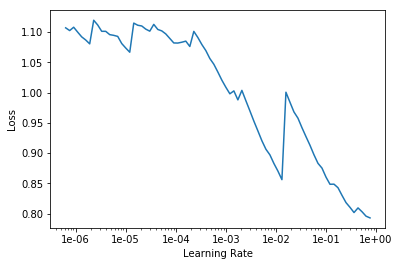

In [216]:
learner.recorder.plot()

In [221]:
learner.fit_one_cycle(10, max_lr=slice(1e-5, 1e-3))

Total time: 08:21
epoch  train_loss  valid_loss
1      0.463796    0.347028    (00:50)
2      0.426471    0.316936    (00:49)
3      0.401791    0.341895    (00:50)
4      0.322207    0.284552    (00:50)
5      0.409105    0.298271    (00:50)
6      0.412383    0.271396    (00:50)
7      0.287195    0.282182    (00:50)
8      0.440449    0.268935    (00:50)
9      0.377717    0.266395    (00:50)
10     0.356524    0.270271    (00:50)



In [222]:
learner.fit_one_cycle(10, max_lr=slice(1e-5, 1e-3))

Total time: 08:21
epoch  train_loss  valid_loss
1      0.316207    0.264135    (00:50)
2      0.607894    0.363948    (00:50)
3      0.513345    0.300386    (00:50)
4      0.361869    0.305230    (00:50)
5      0.386216    0.274495    (00:50)
6      0.330575    0.261882    (00:50)
7      0.538197    0.318821    (00:49)
8      0.320181    0.257891    (00:50)
9      0.296934    0.251992    (00:50)
10     0.287283    0.252724    (00:50)



In [224]:
learner.fit_one_cycle(5, max_lr=slice(1e-5, 1e-3))

Total time: 04:10
epoch  train_loss  valid_loss
1      0.596492    0.402762    (00:49)
2      0.276300    0.279554    (00:50)
3      0.332895    0.287801    (00:50)
4      0.255888    0.252763    (00:50)
5      0.256229    0.254913    (00:50)



In [225]:
learner.save_encoder('encoder_weight')

# classifier

## dataset

In [30]:
x_train_class = np.stack([x_train[t] for t in [tn_5, tn_4, tn_3, tn_2, tn_1, tn]])
x_val_class = np.stack([x_val[t] for t in [tn_5, tn_4, tn_3, tn_2, tn_1, tn]])

In [31]:
db = telcodatabunch.from_df('/', x_train_class, y_train_class, x_val_class, y_val_class, bs = 2048)

## learner

### Build

In [143]:
learner = RNNLearner.creat_model(Path('./models'), db, hidden_sz = 512, n_rnn = 3, 
                                 drop_mult = 0.2, output_drp=0.1, decode_drps = [0.1,0.1], tp = 'classifier')

In [144]:
def loss(input, target):
    input, att_seq_m, att_fea_m = input
    input = input.float(); target = target.float()
    #imbalance
    return F.binary_cross_entropy_with_logits(input, target, weight=target+0.2)

In [145]:
learner.loss_func = loss
learner.metrics = None

### Train

In [238]:
learner.load_encoder('encoder_weight')

In [233]:
learner.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


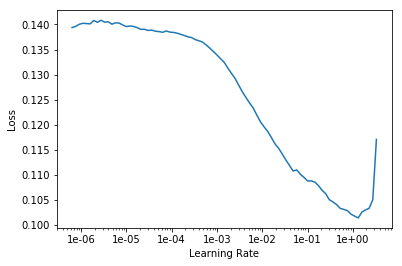

In [234]:
learner.recorder.plot()

In [239]:
learner.fit_one_cycle(5, slice(1e-3, 1e-1))

Total time: 02:13
epoch  train_loss  valid_loss
1      0.063849    0.088429    (00:26)
2      0.064438    0.068159    (00:26)
3      0.063718    0.090590    (00:26)
4      0.061353    0.062032    (00:26)
5      0.059835    0.058715    (00:26)



In [240]:
learner.fit_one_cycle(5, max_lr=slice(1e-3, 1e-1))

Total time: 02:12
epoch  train_loss  valid_loss
1      0.061480    0.061684    (00:26)
2      0.063380    0.061679    (00:26)
3      0.063228    0.068371    (00:26)
4      0.060879    0.062062    (00:26)
5      0.061299    0.058777    (00:26)



In [241]:
learner.save('classifier')

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


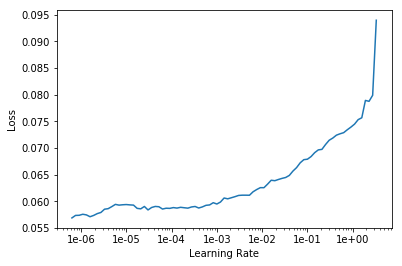

In [242]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [247]:
learner.load('classifier')
learner.unfreeze()

In [248]:
learner.fit_one_cycle(3, max_lr=1e-6)

Total time: 02:55
epoch  train_loss  valid_loss
1      0.058969    0.060224    (00:58)
2      0.061477    0.063955    (00:58)
3      0.059895    0.060917    (00:58)



In [254]:
learner.fit_one_cycle(3, max_lr=1e-7)

Total time: 02:56
epoch  train_loss  valid_loss
1      0.059790    0.104220    (00:58)
2      0.059319    0.059667    (00:58)
3      0.059636    0.059730    (00:58)



In [256]:
learner.fit_one_cycle(3, max_lr=1e-7)

Total time: 02:55
epoch  train_loss  valid_loss
1      0.059509    0.060347    (00:58)
2      0.058920    0.059194    (00:58)
3      0.059323    0.058642    (00:58)



In [257]:
learner.save('classifier')

In [146]:
learner.load('classifier')

### model result 

In [258]:
preds = learner.predict_from_np(db.valid_ds.x, False)

100%|██████████| 90/90 [00:04<00:00, 20.41it/s]


In [259]:
roc = ReceiverOperatingCharacteristic.from_series(db.valid_ds.y, preds)

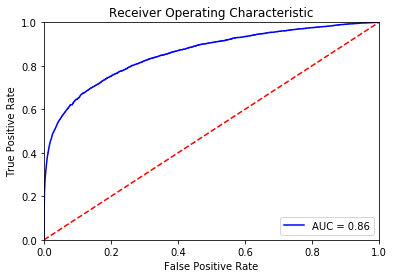

In [260]:
roc.plot()

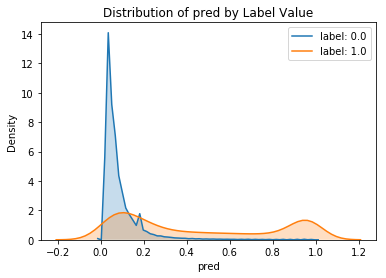

In [261]:
kde = KernelDensityEstimation.from_series('pred', preds, db.valid_ds.y)
kde.plot()

# feature correlation

In [255]:
reshaped = np.transpose(x_train_class, (2, 1, 0)).reshape((25, -1))

In [256]:
ddg = Dendogram.from_series(features, reshaped)

values array is tranposed


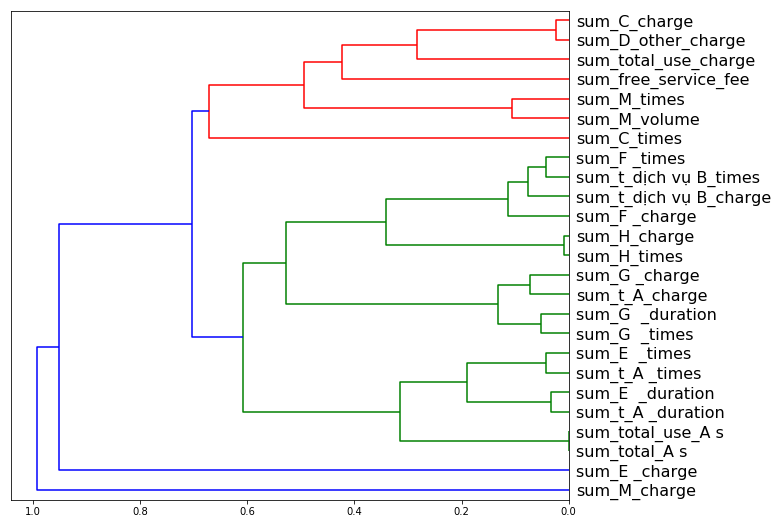

In [257]:
ddg.plot()

In [153]:
group_features = [['sum_total_use_A s','sum_total_A s'], ['sum_H_charge', 'sum_H_times']]
group_features = group_features + [i for i in features if i not in flat_list(group_features)]

# partial dependence

In [147]:
time_range = list(range(-5, 1))

In [148]:
x_transpose = np.transpose(db.valid_ds.x, (1, 0, 2))
x_transpose = numpy_sample(x_transpose, 20000, 0)

num_record = x_transpose.shape[0]
num_space = 50

#fmt = lambda x: "{:.}".format(x)

 58%|█████▊    | 282/489 [00:13<00:09, 20.92it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



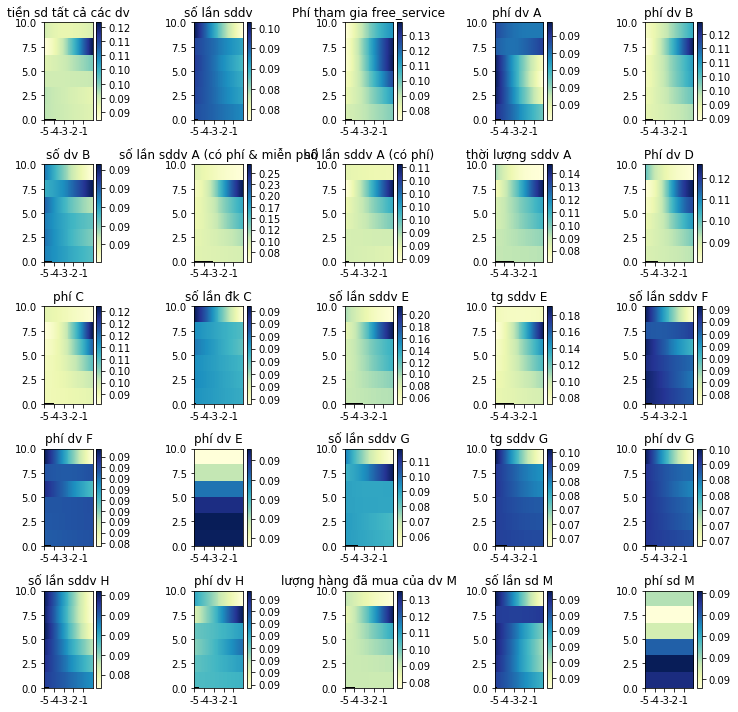

In [149]:
fig = plt.figure(figsize=(10,10))

for f, feature in enumerate(features):
    #if f>3: break
    print(feature_dict[feature]['meaning'], end="\r")
    
    Min, _, _, _, Max, _ = boxnwhisker_value(np.reshape(x_transpose[:,:,f:f+1],-1))
    mean = feature_dict[feature]['mean']                                   
    std = feature_dict[feature]['std']
    x = np.linspace(Min, Max, num_space)
    X, Y = np.meshgrid(x, time_range)
    preds = []
    
    space = np.tile(x, num_record)
    inp = np.concatenate([np.tile(np.array([i]), [num_space,1,1]) for i in x_transpose])
    for m, month in enumerate(time_range):
        inp_m = inp
        inp_m[:,m:m+1,f:f+1] = space[..., None, None]
        pred = learner.predict_from_np(inp_m, False, True)
        pred = [np.mean(pred[np.array([num_space*j+i for j in range(num_record)])]) for i in range(num_space)]
        preds.append(pred)
    preds = np.stack(preds)
    
    ax = fig.add_subplot(5, 5, f+1)
    ax.contourf(X, Y, preds, 20, colors='black')
    
    im = plt.imshow(preds, extent=[0, 5, 0, 10], origin='lower', cmap="YlGnBu")
    plt.xticks(list(range(5)), time_range)
    #plt.yticks(list(range(10)), [fmt(i*std + mean) for i in x])
    plt.colorbar(format=ticker.FormatStrFormatter('%.2f'))
    plt.title(feature_dict[feature]['meaning'])
    

#cbar_ax = fig.add_axes([1.05, 0, 0.05, 0.8])
#fig.colorbar(im, format=ticker.FormatStrFormatter('%.2f'), cax=cbar_ax, label='predict value')

plt.tight_layout()
plt.show()

# shap force plot

In [37]:
def cal_shap(num, m = 150000):
    x_sample = numpy_sample(valx, m, 1)
    features_permute = np.array([np.random.permutation(i) for i in np.tile(np.array(list(range(25))),(m,1))])
    shap_values = []

    for i,f in enumerate(features):
        b1 = [np.concatenate([instance[:,:,:i+1],x_sample[:,j:j+1,fts[i+1:]]],axis=2) for j, fts in enumerate(features_permute)]
        b1 = np.concatenate(b1,axis=1)

        b2 = [np.concatenate([instance[:,:,:i],x_sample[:,j:j+1,fts[i:]]],axis=2) for j, fts in enumerate(features_permute)]
        b2 = np.concatenate(b2,axis=1)

        phi = np.sum(learner.predict_from_np(b1,False) - learner.predict_from_np(b2,False))/m
        shap_values.append(phi)
    return shap_values

In [42]:
mask = [i for i,j in enumerate(y_pred) if j>0.8]

## #7

In [119]:
num_mask = 7
num = mask[num_mask]
instance = valx[:,num:num+1,:]
num_mask, num, y_pred[num]

(7, 1339, 0.9982066)

In [ ]:
shap_values = cal_shap(num)

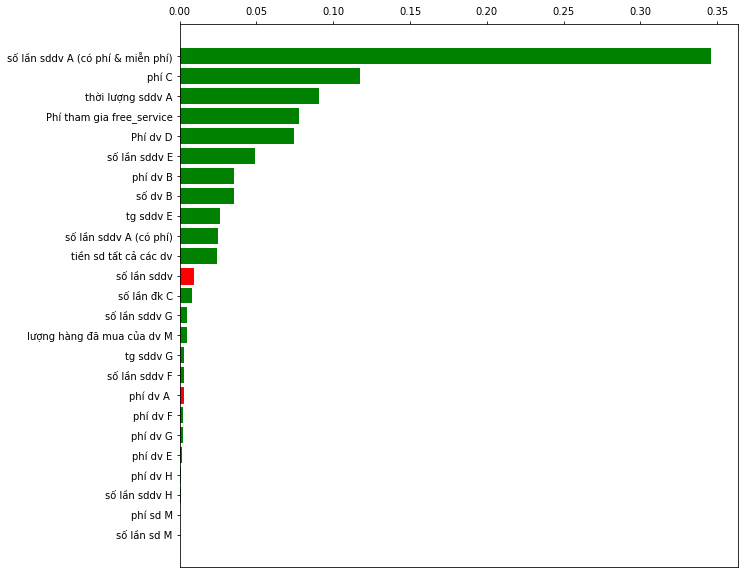

In [121]:
plot_barh_from_series([feature_dict[i]['meaning'] for i in features], shap_values, absolute=True, figsize = (10,10))

In [122]:
np.sum(shap_values)

0.9218123699315389

## #8

In [123]:
num_mask = 8
num = mask[num_mask]
instance = valx[:,num:num+1,:]
num_mask, num, y_pred[num]

(8, 1358, 0.88550395)

In [ ]:
shap_values = cal_shap(num)

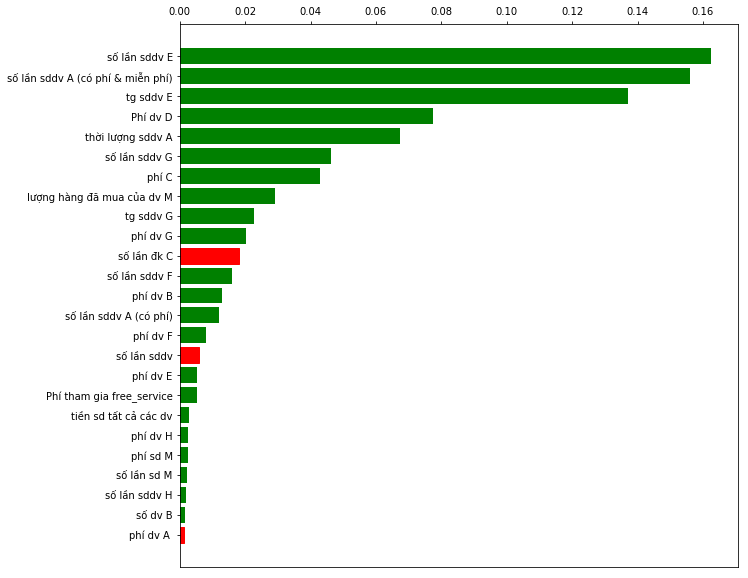

In [125]:
plot_barh_from_series([feature_dict[i]['meaning'] for i in features], shap_values, absolute=True, figsize = (10,10))

In [127]:
np.sum(shap_values)

0.8091073454793295

# attention plot 

In [57]:
_, att_seq, att_fea = learner.predict_from_np(valx)

100%|██████████| 90/90 [00:04<00:00, 20.13it/s]


## attention and sequence

In [58]:
def att_seq_plot(num, figsize = (10,10)):
    plt.figure(figsize=figsize)
    sns.heatmap(att_seq[num].T, xticklabels = time_range, 
                yticklabels=[feature_dict[f]['meaning'] for f in features], 
                cmap="YlGnBu",)

In [59]:
time_range = list(range(-5, 1))

### #7

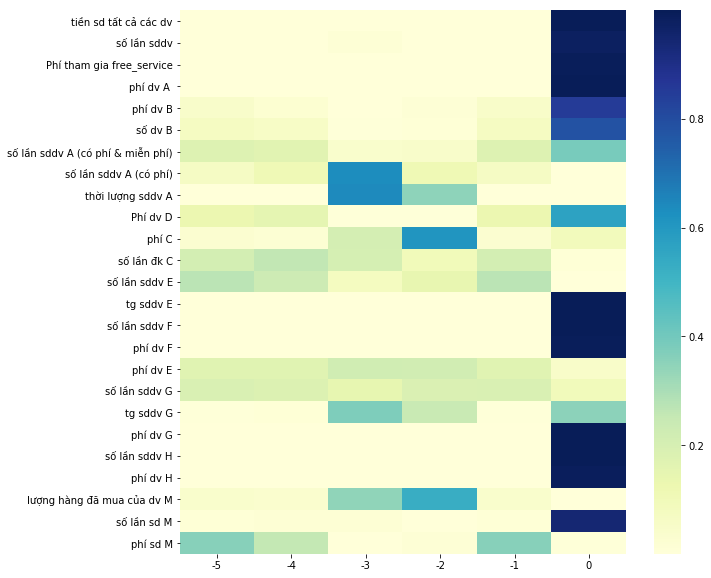

In [128]:
att_seq_plot(mask[7]) #7

### #8

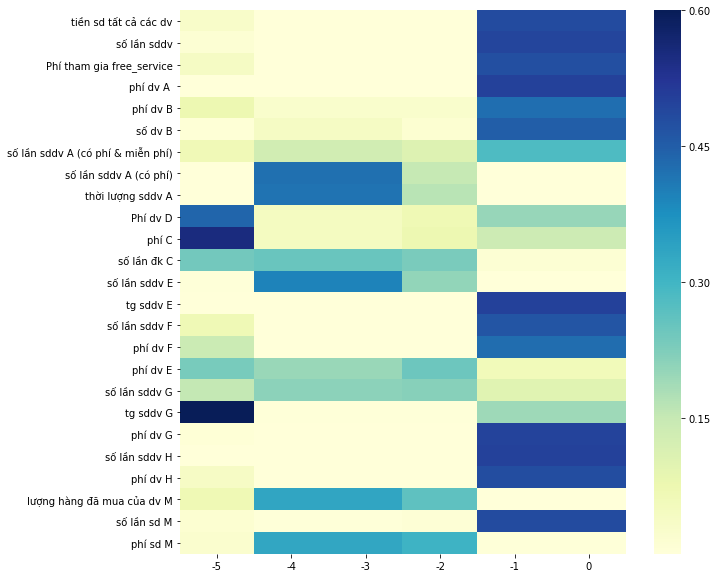

In [130]:
att_seq_plot(mask[8]) #8

## attention and values of variable

In [63]:
def att_and_var_plot(num):
    instance = valx[:,num:num+1,:]
    
    fig = plt.figure(figsize=(10,10))
    for f, feature in enumerate(features):
        fig.add_subplot(5, 5, f+1)
        instance_origin = instance[:,:,f]*feature_dict[feature]['std']+feature_dict[feature]['mean']
        sns.lineplot(x=time_range, y=np.squeeze(instance_origin), alpha = 0.2)
        sns.scatterplot(x=time_range, y=np.squeeze(instance_origin), 
                        hue=att_seq[num][:,f], size=att_seq[num][:,f], 
                        sizes=(50, 200),#50 + 300*att_fea[num][f] 
                        legend = False, palette="YlGnBu")    
        plt.title(feature_dict[feature]['meaning'])

    plt.tight_layout()
    plt.show()

### #7

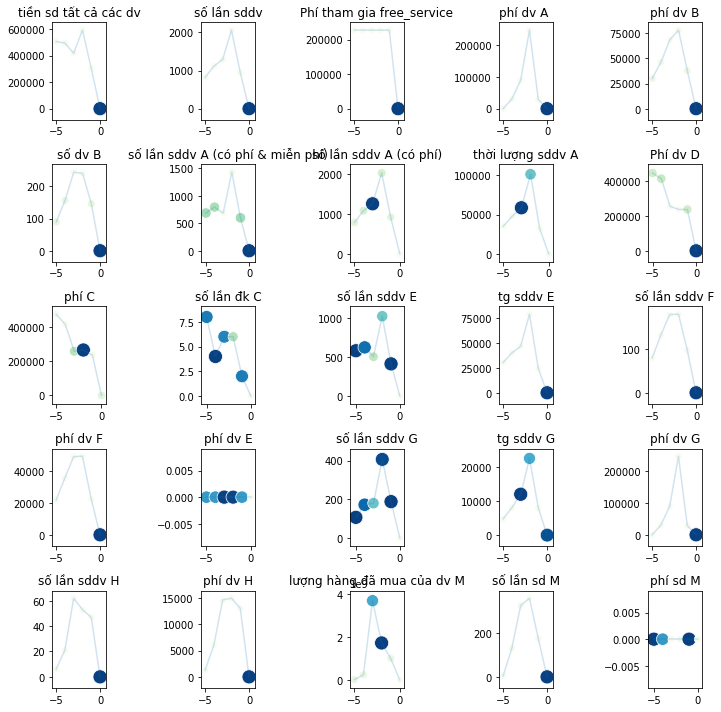

In [131]:
att_and_var_plot(mask[7]) #7

### #8

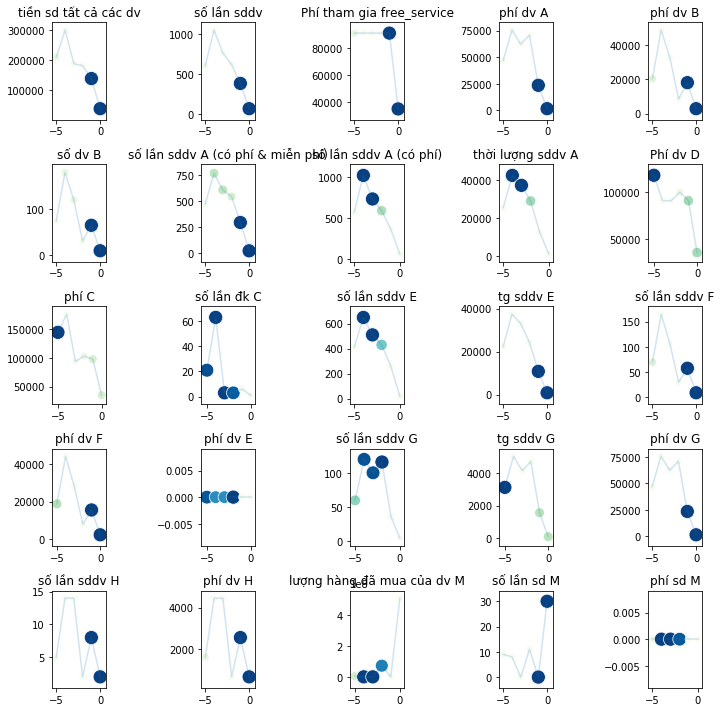

In [132]:
att_and_var_plot(mask[8]) #8